# Data Processing

This notebook demonstrates how preprocessing metagenomic data may aid their classification.

In [1]:
import os
import json
from stelaro.data import format, ncbi, synthetic
import numpy as np
import random

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/final/"
BERTAX_DATASET_DIRECTORY = BERTAX_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)
BERTAX_STATISTIC_DIRECTORY = BERTAX_DIRECTORY + "statistics/"
SEQUENCE_LENGTH = 1500
N_MINIMUM_READS_PER_TAXON = 10_000


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(BERTAX_STATISTIC_DIRECTORY)

## 1. Dataset Analysis

### 1.1. Obtain Taxa

In [6]:
tax_ids = set()
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)

parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)


def get_level_0(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "domain":
            return level[1]
    for level in lineages[tax_id]:
        if level[-1] == "realm":
            return "Viruses"
    return None


def get_level_1(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "phylum":
            return level[1]
    return None


def get_taxon(line):
    tax_id = line.strip()
    tax_id = tax_id.replace(">", "")
    tax_id = tax_id.split(" ")[0]
    domain = get_level_0(tax_id)
    phylum = get_level_1(tax_id)
    if domain and phylum:
        current_taxon = (domain, phylum)
    else:
        current_taxon = None
    return current_taxon


def get_mappings(file: str) -> dict:
    taxa = {}
    total = 0
    retained = 0
    current_taxon = None
    with open(file, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
                current_taxon = get_taxon(line)
            elif current_taxon:
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    retained += 1
                    if current_taxon in taxa:
                        taxa[current_taxon] += 1
                    else:
                        taxa[current_taxon] = 1
    print(f"{retained} / {total}")
    return taxa

taxa = {}
for domain in BERTAX_DOMAINS:
    taxa |= get_mappings(BERTAX_DATASET_DIRECTORY + domain)

Taxon 1740162 is nameless.
Taxon 1588685 is nameless.
Taxon 1980519 is nameless.
Taxon 1986224 is nameless.
Taxon 1535802 is nameless.
Taxon 55097 is nameless.
Taxon 1980494 is nameless.
Taxon 11623 is nameless.
Taxon 2487073 is nameless.
Taxon 35310 is nameless.
Taxon 1759437 is nameless.
Taxon 35306 is nameless.
Taxon 743685 is nameless.
Taxon 85643 is nameless.
Taxon 2169992 is nameless.
Taxon 11191 is nameless.
Taxon 2546450 is nameless.
Taxon 1979163 is nameless.
Taxon 1979166 is nameless.
Taxon 122203 is nameless.
Taxon 740710 is nameless.
Taxon 623144 is nameless.
Taxon 12332 is nameless.
Taxon 62928 is nameless.
Taxon 1547445 is nameless.
Taxon 63330 is nameless.
Taxon 218387 is nameless.
Taxon 42764 is nameless.
Taxon 319236 is nameless.
Taxon 287094 is nameless.
Taxon 1673076 is nameless.
Taxon 55096 is nameless.
Taxon 35302 is nameless.
Taxon 262071 is nameless.
Taxon 220622 is nameless.
Taxon 207246 is nameless.
Taxon 1637841 is nameless.
Taxon 1980486 is nameless.
Taxon 11

In [7]:
total = 0
n_sequences = 0
n_taxa = 0
retained = []
for t, n in taxa.items():
    total += n
    if n >= N_MINIMUM_READS_PER_TAXON:
        print(t, n)
        n_sequences += n
        n_taxa += 1
        retained.append(t)
    else:
        print(f"{t} dropped ({n})")
delta = total - n_sequences
print(f"{n_sequences} / {total} reads ({delta} dropped). {n_taxa} taxa.")

mappings = {}
for i, taxon in enumerate(sorted(retained)):
    mappings[str(i)] = taxon
with open(BERTAX_STATISTIC_DIRECTORY + "map.json", "w") as f:
    json.dump(mappings, f, indent=4)

reversed_map = {v: k for k, v in mappings.items()}

('Archaea', 'Thermoproteota') 121632
('Archaea', 'Methanobacteriota') 312457
('Archaea', 'Nitrososphaerota') 59890
('Archaea', 'Thermoplasmatota') 41128
('Bacteria', 'Pseudomonadota') 576465
('Bacteria', 'Bacillota') 175591
('Bacteria', 'Bdellovibrionota') 34491
('Bacteria', 'Thermodesulfobacteriota') 56957
('Bacteria', 'Actinomycetota') 324374
('Bacteria', 'Campylobacterota') 28549
('Bacteria', 'Cyanobacteriota') 71022
('Bacteria', 'Fusobacteriota') 16581
('Bacteria', 'Chloroflexota') 59196
('Bacteria', 'Aquificota') 10525
('Bacteria', 'Bacteroidota') 123146
('Bacteria', 'Verrucomicrobiota') 26406
('Bacteria', 'Deinococcota') 29335
('Bacteria', 'Chlamydiota') 22473
('Bacteria', 'Lentisphaerota') 10942
('Bacteria', 'Mycoplasmatota') 47952
('Bacteria', 'Planctomycetota') 74762
('Bacteria', 'Chlorobiota') 13792
('Bacteria', 'Nitrospirota') 16852
('Bacteria', 'Spirochaetota') 36380
('Bacteria', 'Thermotogota') 32696
('Bacteria', 'Gemmatimonadota') 13353
('Bacteria', 'Elusimicrobiota') dro

In [8]:
y = np.zeros(n_sequences, dtype=np.uint16)
i = 0

for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                total += 1
                current_taxon = get_taxon(line)
            elif current_taxon in reversed_map:
                taxon_index = reversed_map[current_taxon]
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    y[i] = taxon_index
                    i += 1

print(f"Expected {n_sequences}, read {i}. Difference: {n_sequences - i}.")

np.save(BERTAX_STATISTIC_DIRECTORY + "y.npy", y)

Expected 5294663, read 5294663. Difference: 0.


[ 312457   59890   41128  121632  324374   10525  175591  123146   34491
   28549   22473   13792   59196   71022   29335   16581   13353   10942
   47952   21961   16852   74762  576465   13160   36380   56957   32696
   26406   77703  144519  205272   41400   60635   24785 1280886   26851
   21456   87372   28161   27662   18269  625913   21632   23007   39710
   37411   47118   25148   57685]
Total N reads: 5294663
Minimum N reads: 10525 - Maximum N reads: 1280886


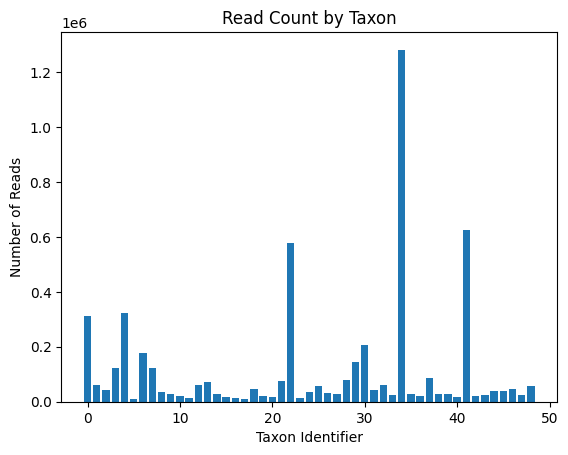

In [9]:
counts = np.bincount(y)
print(counts)
print(f"Total N reads: {sum(counts)}")
print(f"Minimum N reads: {min(counts)} - Maximum N reads: {max(counts)}")

import matplotlib.pyplot as plt
plt.bar(list(range(len(counts))), counts)
plt.xlabel("Taxon Identifier")
plt.ylabel("Number of Reads")
plt.title("Read Count by Taxon")
plt.show()

### 1.2. Create Distinct Sets

In [11]:
y = np.load(BERTAX_STATISTIC_DIRECTORY + "y.npy")
N = y.shape[0]

with open(BERTAX_STATISTIC_DIRECTORY + "map.json", "r") as f:
    mappings = json.load(f)
reversed_map = {tuple(v): k for k, v in mappings.items()}

In [18]:
random.seed(7)


def plan_datasets(test_minimum: int, train_maximum: int, validation_fraction: float) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        test_minimum: Minimum number of reads in each taxon for the test set.
        train_maximum: Maximum number of reads per taxon in the train set.
        validation_fraction: Fraction of training reads to use for validation.
    """
    taxon_to_read_IDs = {k: [] for k in mappings}
    i = 0
    # Find identifiers
    for domain in BERTAX_DOMAINS:
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_taxon = None
            for line in f:
                if line.startswith(">"):
                    current_taxon = get_taxon(line)
                elif current_taxon in reversed_map:
                    taxon_index = reversed_map[current_taxon]
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[taxon_index].append(i)
                        i += 1
    # Select test and train data
    train = {k: [] for k in mappings}
    validation = {k: [] for k in mappings}
    test = {k: [] for k in mappings}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:test_minimum]
        train_data = taxon_to_read_IDs[taxon][test_minimum:train_maximum + test_minimum]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    return train, validation, test

In [ ]:
M = SEQUENCE_LENGTH // 4  # Encode on tetramers to save memory.
datasets = plan_datasets(2000, 30_000, 0.05)

for dataset, name in zip(datasets, ("train", "validation", "test")):
    mkdir(BERTAX_DIRECTORY + name + "/")
    elements = set()
    for taxon in dataset:
        elements.update(dataset[taxon])
    N = len(elements)
    x = np.zeros((N, M), dtype=np.uint8)
    y = np.zeros(N, dtype=np.uint16)
    i = 0
    local_i = 0
    for domain in BERTAX_DOMAINS:
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_taxon = None
            for line in f:
                if line.startswith(">"):
                    total += 1
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    domain = get_level_0(tax_id)
                    phylum = get_level_1(tax_id)
                    if domain and phylum:
                        current_taxon = (domain, phylum)
                    else:
                        current_taxon = None
                elif current_taxon in reversed_map:
                    taxon_index = reversed_map[current_taxon]
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        if i in elements:
                            encoding = format.encode_tetramer(sequence)
                            x[local_i] = encoding
                            y[local_i] = taxon_index
                            local_i += 1
                        i += 1
    assert local_i == N
    np.save(BERTAX_DIRECTORY + name + "/x.npy", x)
    np.save(BERTAX_DIRECTORY + name + "/y.npy", y)

## 2. Test Models

In [2]:
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_VALIDATION = BERTAX_DIRECTORY + "validation/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"

from stelaro import models
import numpy as np
from torch import tensor
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import bincount
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer, hybrid
from time import time

LENGTH = 1500
BATCH_SIZE = 128


train_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TRAIN),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_VALIDATION),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TEST),
    batch_size=BATCH_SIZE,
    shuffle=True
)

with open(BERTAX_DIRECTORY + "statistics/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(
        classifier: models.BaseClassifier,
        name: str,
        max_epochs: int = 20
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, validation_losses = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=3,
        permute=False
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training Loss")
        ax[0].plot(x, validation_losses, label="Validation Loss")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.long().to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

### 2.1. Baseline

100%|██████████| 9196/9196 [00:18<00:00, 492.43it/s]


Training took 18.681 s.
Test results: [0.24573, 0.01613]


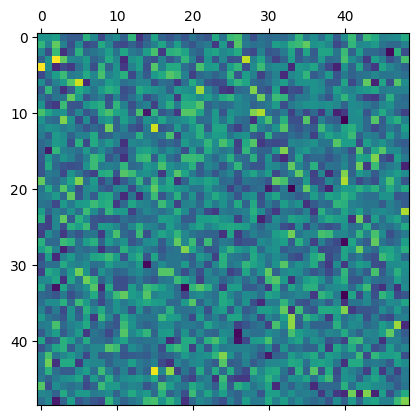

[[44. 44. 46. ... 42. 43. 48.]
 [50. 41. 54. ... 37. 37. 41.]
 [42. 33. 51. ... 24. 49. 33.]
 ...
 [53. 33. 43. ... 40. 35. 39.]
 [42. 41. 36. ... 33. 41. 48.]
 [38. 42. 26. ... 41. 51. 56.]]


In [27]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
)
model.n_classes = len(mapping)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 2.2. CNN

Number of parameters: 24_623_505


  0%|          | 0/9196 [00:00<?, ?it/s]


1/5 Loss: 0.03. F1: [0.15535, 0.00027648]. Patience: 3


  0%|          | 0/9196 [00:00<?, ?it/s]


2/5 Loss: 0.03. F1: [0.15529, 0.0009589]. Patience: 3


  0%|          | 0/9196 [00:00<?, ?it/s]


3/5 Loss: 0.03. F1: [0.11586, 0.00095712]. Patience: 2


  0%|          | 0/9196 [00:00<?, ?it/s]


4/5 Loss: 0.03. F1: [0.11585, 0.00095876]. Patience: 1


  0%|          | 0/9196 [00:00<?, ?it/s]


5/5 Loss: 0.03. F1: [0.11588, 0.00095837]. Patience: 0
The model is overfitting; stopping early.
Training took 57.038 s.


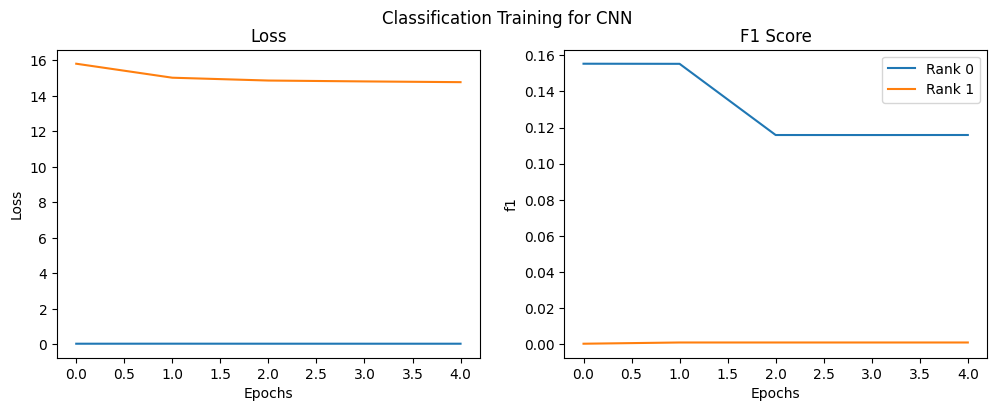

Test results: [0.11071, 0.0008096]


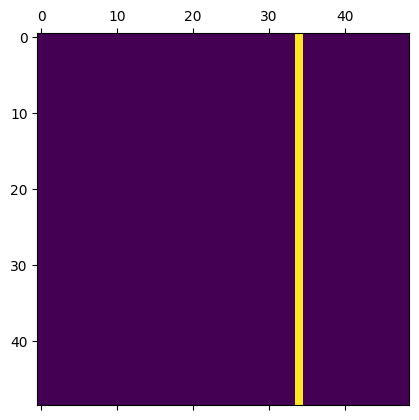

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32, argmax
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, 64),
            ReLU(),
            Dropout(0.2),
            Linear(64, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.float()


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
    max_epochs=5
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 2.3. Transformer

In [29]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

Number of parameters: 483_633


100%|██████████| 9196/9196 [16:20<00:00,  9.37it/s]


1/20 Loss: 13052.11. F1: [0.82433, 0.58564]. Patience: 3


100%|██████████| 9196/9196 [24:45<00:00,  6.19it/s]     


2/20 Loss: 8897.78. F1: [0.84817, 0.62551]. Patience: 3


100%|██████████| 9196/9196 [16:11<00:00,  9.46it/s]


3/20 Loss: 8012.24. F1: [0.86168, 0.65004]. Patience: 3


100%|██████████| 9196/9196 [1:39:00<00:00,  1.55it/s]     


4/20 Loss: 7562.56. F1: [0.86921, 0.65769]. Patience: 3


100%|██████████| 9196/9196 [16:06<00:00,  9.52it/s]


5/20 Loss: 7260.37. F1: [0.86485, 0.66068]. Patience: 3


100%|██████████| 9196/9196 [16:33<00:00,  9.26it/s]


6/20 Loss: 7038.74. F1: [0.87648, 0.67086]. Patience: 3


100%|██████████| 9196/9196 [16:31<00:00,  9.28it/s]


7/20 Loss: 6869.58. F1: [0.87449, 0.67437]. Patience: 3


100%|██████████| 9196/9196 [16:31<00:00,  9.27it/s]


8/20 Loss: 6723.84. F1: [0.88087, 0.6794]. Patience: 3


100%|██████████| 9196/9196 [16:35<00:00,  9.24it/s]


9/20 Loss: 6606.20. F1: [0.88192, 0.68177]. Patience: 3


100%|██████████| 9196/9196 [16:40<00:00,  9.20it/s]


10/20 Loss: 6503.28. F1: [0.88174, 0.68244]. Patience: 3


100%|██████████| 9196/9196 [16:45<00:00,  9.15it/s]


11/20 Loss: 6408.71. F1: [0.88285, 0.68406]. Patience: 3


100%|██████████| 9196/9196 [16:42<00:00,  9.17it/s]


12/20 Loss: 6329.92. F1: [0.88203, 0.68682]. Patience: 3


 39%|███▉      | 3593/9196 [06:31<10:10,  9.17it/s]


KeyboardInterrupt: 